In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *

## First load a few images to identify ROIs and check threshold

In [4]:
# data = SFDataFiles('/sf/alvra/data/p19506/raw/static_data/011_XES_ZnFoil_9800pink/run_000526*')
data = SFDataFiles('/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_001/run_001381.JF02T09V02.h5')
nframes = 1000
threshold_low = 2

# Choose a pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals) 
# if you do not want to use the closest in time

# pedestal_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190727_2115.JF02T09V02.res.h5"
pedestal_file = None

##################################################################
clock = Clock()
total = 0
total_thr = 0
ch_JF = data['JF02T09V02']
images = ch_JF.data[:nframes]

print ('Loaded {} images'.format(images.shape[0]))

for i in range(nframes):
    single_image = images[i, :]
    image_thr = single_image.copy()
    image_thr[single_image < threshold_low] = 0
    total_thr += image_thr
    total += single_image
    #total /= nframes

print ("It took", clock.tick(), "seconds to process this file")

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_001194.JF02T09V02.res.h5
jungfrau file: 21:00 13.11.2021
pedestal file: 19:26 13.11.2021
    mtime difference: 1:34:09.033649
Loaded 1000 images
It took 20.11 seconds to process this file


<IPython.core.display.Javascript object>


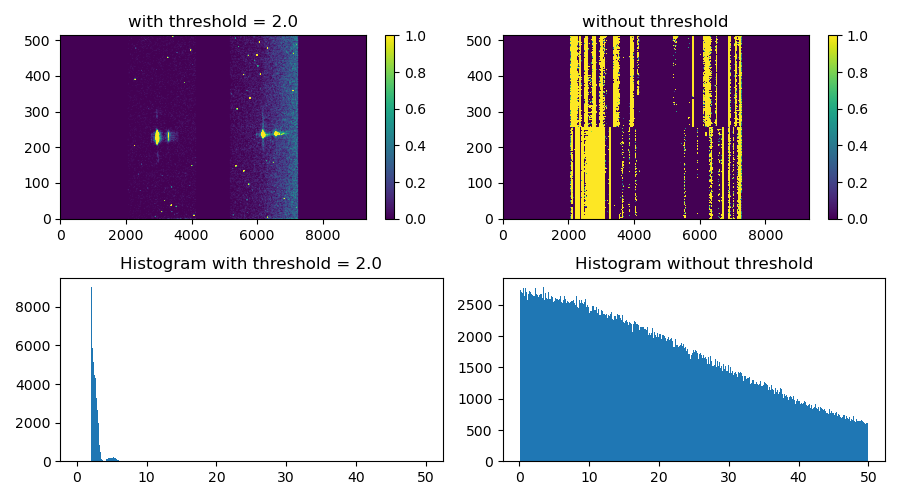

In [204]:
plt.figure(figsize=(9,5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(221)
plt.imshow(total_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()
plt.subplot(222)
plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("without threshold")
plt.colorbar()
plt.subplot(224)
plt.title("Histogram without threshold")
plt.hist(total.ravel(), bins=np.arange(0.1,50,0.1))
plt.subplot(223)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_thr.ravel(), bins=np.arange(0.1,50,0.1))
plt.tight_layout()
plt.show()

## Next cells for a single file, ONLY JF file!

In [16]:
DIR = '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_001/'
run = 'run_001381'

In [205]:
roi1 = (2600, 3600, 200, 260) #signal 1
roi2 = (2600, 3600, 100, 160) #bkg 1

roi3 = (5900, 6900, 200, 260) #signal 2
roi4 = (5900, 6900, 100, 160) #bkg 2

threshold_low = 2
threshold_high = 20

######################################################################################
clock = Clock()
JF_single_file = DIR + run + '.JF02T09V02.h5'

spectrum_roi1 = 0
spectrum_roi2 = 0
spectrum_roi3 = 0
spectrum_roi4 = 0

print("Processing file %s" % (JF_single_file))
clear_output(wait=True)
nshots = None
images_roi1, images_roi2, images_roi3, images_roi4, pids = \
    load_crop_JF_batches(JF_single_file, roi1, roi2, roi3, roi4, nshots=nshots)

images_roi1_thr = images_roi1.copy()
images_roi1_thr[images_roi1 < threshold_low] = 0
images_roi1_thr[images_roi1 > threshold_high] = 0
images_roi1_thr = convert_to_photon_num_range(images_roi1_thr, [threshold_low,threshold_high])

images_roi2_thr = images_roi2.copy()
images_roi2_thr[images_roi2 < threshold_low] = 0
images_roi2_thr[images_roi2 > threshold_high] = 0
images_roi2_thr = convert_to_photon_num_range(images_roi2_thr, [threshold_low,threshold_high])

images_roi3_thr = images_roi3.copy()
images_roi3_thr[images_roi3 < threshold_low] = 0
images_roi3_thr[images_roi3 > threshold_high] = 0
images_roi3_thr = convert_to_photon_num_range(images_roi3_thr, [threshold_low,threshold_high])

images_roi4_thr = images_roi4.copy()
images_roi4_thr[images_roi4 < threshold_low] = 0
images_roi4_thr[images_roi4 > threshold_high] = 0
images_roi4_thr = convert_to_photon_num_range(images_roi4_thr, [threshold_low,threshold_high])

spectrum_roi1  += images_roi1_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi2  += images_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi3  += images_roi3_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi4  += images_roi4_thr.sum(axis = 1).sum(axis = 0)

print ("It took", clock.tick(), "seconds to process this file")

#print ("It took", clock.tock(), "seconds to process {} files".format(len(patch)))

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_001194.JF02T09V02.res.h5
jungfrau file: 21:00 13.11.2021
pedestal file: 19:26 13.11.2021
    mtime difference: 1:34:09.033649
Total images = 2001, load them in batches of 1000
Load batch = slice(0, 1000, None)
Load batch = slice(1000, 2000, None)
Load batch = slice(2000, 2001, None)
It took 10.72 seconds to process this file


/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


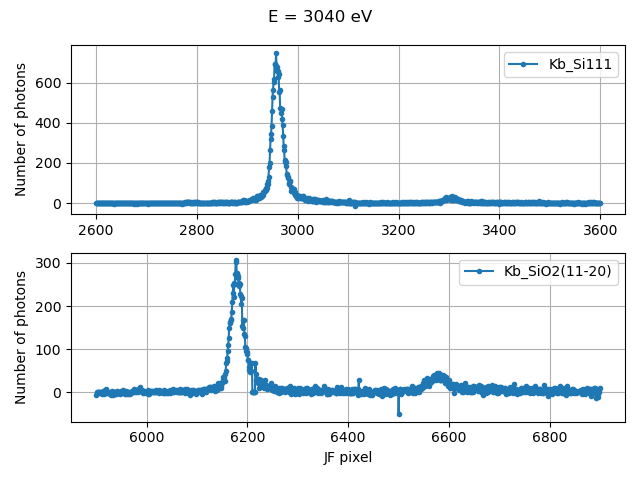

In [211]:
spectrum_bkg_roi1 = spectrum_roi1  - spectrum_roi2
err_spectrum_ro1 = np.sqrt(spectrum_roi1)
err_bkg_2 = np.sqrt(spectrum_roi2)

spectrum_bkg_roi3 = spectrum_roi3 - spectrum_roi4
err_spectrum_roi3 = np.sqrt(spectrum_roi3)
err_bkg_4 = np.sqrt(spectrum_roi4)


bin1_ = 1   # change the bin size if wanted, 1 is every pixel
bin3_ = 1

spectrum_bkg_1 = spectrum_bkg_roi1.copy()
spectrum_bkg_3 = spectrum_bkg_roi3.copy()
x_axis_1 = np.arange(roi1[0], roi1[1])
x_axis_3 = np.arange(roi3[0], roi3[1])


spectrum_rebin1  = bin_sum(spectrum_bkg_1,  bin1_)
x_axis_rebin1 = bin_mean(x_axis_1, bin1_)
spectrum_rebin3  = bin_sum(spectrum_bkg_3,  bin3_)
x_axis_rebin3 = bin_mean(x_axis_3, bin3_)


#low_err_Ka= (spectrum_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#high_err_Kb= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.suptitle("E = 3040 eV")
plt.subplot(211)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectrum_rebin1, label="Kb_Si111", marker='.')
plt.ylabel('Number of photons')
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin3, spectrum_rebin3, label="Kb_SiO2(11-20)", marker='.')
plt.ylabel('Number of photons')
plt.legend(loc="best")
plt.grid()
plt.xlabel("JF pixel")
plt.tight_layout()
plt.show()

## Next cells for a single file, any channel (BSDATA & JF) 

In [55]:
# Choose a pedestal file (usually located in /sf/alvra/data/*pgroup*/raw/JF_pedestals) 
# if you do not want to use the closest in time
# If 'None' the closest in time is selected

# pedestal_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190727_2115.JF02T09V02.res.h5"
pedestal_file = None

In [57]:
data = SFDataFiles('/sf/alvra/data/p18938/raw/XES_jet/run_008899*')

channel_list = [channel_PIPS_fluo, channel_Izero117, 'JF02T09V02']

roi1 = (7740, 7880, 290, 340) #signal 1
roi2 = (7740, 7880, 385, 435) #bkg 1

roi3 = (5080, 5220, 210, 250) #signal 2
roi4 = (5080, 5220, 145, 185) #bkg 2

threshold_low = 5

##########################################################
clock = Clock()
spectrum_roi1 = 0
spectrum_roi2 = 0
spectrum_roi3 = 0
spectrum_roi4 = 0
print (data.fnames[0])

results = load_data_compact_JF(channel_list, data, roi1, roi2, roi3, roi4)

data.close()

Data_fluo = results[channel_PIPS_fluo]
images_roi1 = results['JFroi1']
images_roi2 = results['JFroi2']
images_roi3 = results['JFroi3']
images_roi4 = results['JFroi4']

images_roi1_thr = images_roi1.copy()
images_roi1_thr[images_roi1 < threshold_low] = 0
#images_roi1_thr[images_roi1 > threshold_high] = 0

images_roi2_thr = images_roi2.copy()
images_roi2_thr[images_roi2 < threshold_low] = 0
#images_roi2_thr[images_roi2 > threshold_high] = 0

images_roi3_thr = images_roi3.copy()
images_roi3_thr[images_roi3 < threshold_low] = 0
#images_roi3_thr[images_roi3 > threshold_high] = 0

images_roi4_thr = images_roi4.copy()
images_roi4_thr[images_roi4 < threshold_low] = 0
#images_roi4_thr[images_roi4 > threshold_high] = 0

spectrum_roi1 = images_roi1_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi2 = images_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi3 = images_roi3_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi4 = images_roi4_thr.sum(axis = 1).sum(axis = 0)

print ("It took", clock.tick(), "seconds to process this file")

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_008336.JF02T09V02.res.h5
jungfrau file: 13:14 26.02.2021
pedestal file: 20:10 25.02.2021
    mtime difference: 17:03:54.322510
/sf/alvra/data/p18938/raw/XES_jet/run_008899.BSDATA.h5

--------------------------------------------------------------------------------

JF02T09V02                2000 / 8000 -> 75% loss ▇▇
SAR-CVME-TIFALL5:EvtSet   8000 / 8000 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  2000 / 8000 -> 75% loss ▇▇
SAROP11-PBPS117:INTENSITY 1987 / 8000 -> 75% loss ▇▇

over the whole data set: 1987 / 8000 -> 75% loss
complete channels: 1 / 4 -> 75% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
It took 31.59 seconds to process this file


<IPython.core.display.Javascript object>


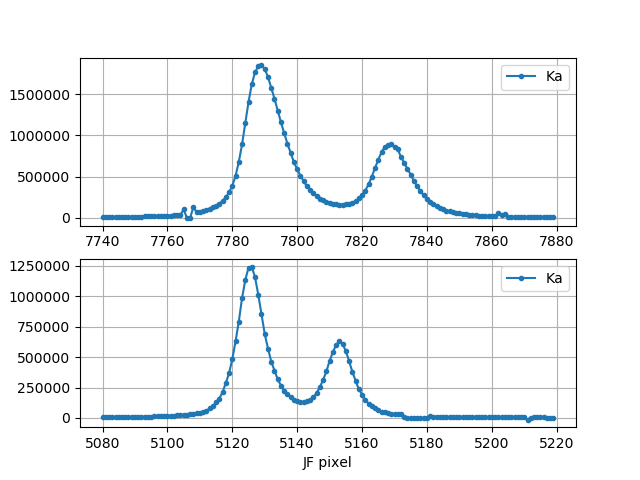

In [8]:
spectrum_bkg_roi1 = spectrum_roi1  - spectrum_roi2
err_spectrum_ro1 = np.sqrt(spectrum_roi1)
err_bkg_2 = np.sqrt(spectrum_roi2)

spectrum_bkg_roi3 = spectrum_roi3 - spectrum_roi4
err_spectrum_roi3 = np.sqrt(spectrum_roi3)
err_bkg_4 = np.sqrt(spectrum_roi4)


bin1_ = 1   # change the bin size if wanted, 1 is every pixel
bin3_ = 1

spectrum_bkg_1 = spectrum_bkg_roi1.copy()
spectrum_bkg_3 = spectrum_bkg_roi3.copy()
x_axis_1 = np.arange(roi1[0], roi1[1])
x_axis_3 = np.arange(roi3[0], roi3[1])


spectrum_rebin1  = bin_sum(spectrum_bkg_1,  bin1_)
x_axis_rebin1 = bin_mean(x_axis_1, bin1_)
spectrum_rebin3  = bin_sum(spectrum_bkg_3,  bin3_)
x_axis_rebin3 = bin_mean(x_axis_3, bin3_)


#low_err_Ka= (spectrum_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#high_err_Kb= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectrum_rebin1, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin3, spectrum_rebin3, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)
plt.xlabel("JF pixel")
plt.show()

## Next cells for scans, ONLY JF file!

In [29]:
fc = FileChooser('/sf/alvra/data/p19262/raw/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [212]:
savedir = '/das/work/p19/p19262/Claudio/Export_PNG'
os.makedirs(savedir, exist_ok=True)
print (savedir)

/das/work/p19/p19262/Claudio/Export_PNG


/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
roi1 = (2600, 3600, 200, 260) #signal 1
roi2 = (2600, 3600, 100, 160) #bkg 1

roi3 = (5900, 6900, 200, 260) #signal 2
roi4 = (5900, 6900, 100, 160) #bkg 2

threshold_low = 2.0
threshold_high = 10

channel_list = ['JF02T09V02']

######################################################################################

from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

XAS_roi1 = []
XAS_roi3 = []
calibration = []
RIXS_roi1 = []
RIXS_roi3 = []

for i, step in enumerate(scan.files):
    
    fn = step[3]
    print("File {} out of {}: Processing {}".format(i+1, len(scan.files), fn.split('/')[-1]))
    
    spectrum_roi1 = 0
    spectrum_roi2 = 0
    spectrum_roi3 = 0
    spectrum_roi4 = 0
    
    nshots = None
    
    images_roi1, images_roi2, images_roi3, images_roi4, pids = \
    load_crop_JF_batches(fn, roi1, roi2, roi3, roi4, nshots=nshots)
    
    images_roi1_thr = images_roi1.copy()
    images_roi1_thr[images_roi1 < threshold_low] = 0
    images_roi1_thr[images_roi1 > threshold_high] = 0

    images_roi2_thr = images_roi2.copy()
    images_roi2_thr[images_roi2 < threshold_low] = 0
    images_roi2_thr[images_roi2 > threshold_high] = 0

    images_roi3_thr = images_roi3.copy()
    images_roi3_thr[images_roi3 < threshold_low] = 0
    images_roi3_thr[images_roi3 > threshold_high] = 0

    images_roi4_thr = images_roi4.copy()
    images_roi4_thr[images_roi4 < threshold_low] = 0
    images_roi4_thr[images_roi4 > threshold_high] = 0

    
    spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
    XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
    #print (np.argmax(spectrum_roi3 - spectrum_roi4))
    calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

    RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
    RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
    clear_output(wait=True)
    print ("It took", clock.tick(), "seconds to process this file")


XAS_roi1 = np.array(XAS_roi1)
calibration = np.array(calibration)
RIXS_roi1 = np.array(RIXS_roi1)

print ("\nJob done! It took", clock.tock(), "seconds to process", num_scan_files, "file(s)")

It took 7.65 seconds to process this file

Job done! It took 4577.02 seconds to process 101 file(s)


In [182]:
RIXS_roi1_all_photons = convert_to_photon_num_range(np.sum(RIXS_roi1_all, axis = 0), [threshold_low,threshold_high])
RIXS_roi3_all_photons = convert_to_photon_num_range(np.sum(RIXS_roi3_all, axis = 0), [threshold_low,threshold_high])

<IPython.core.display.Javascript object>


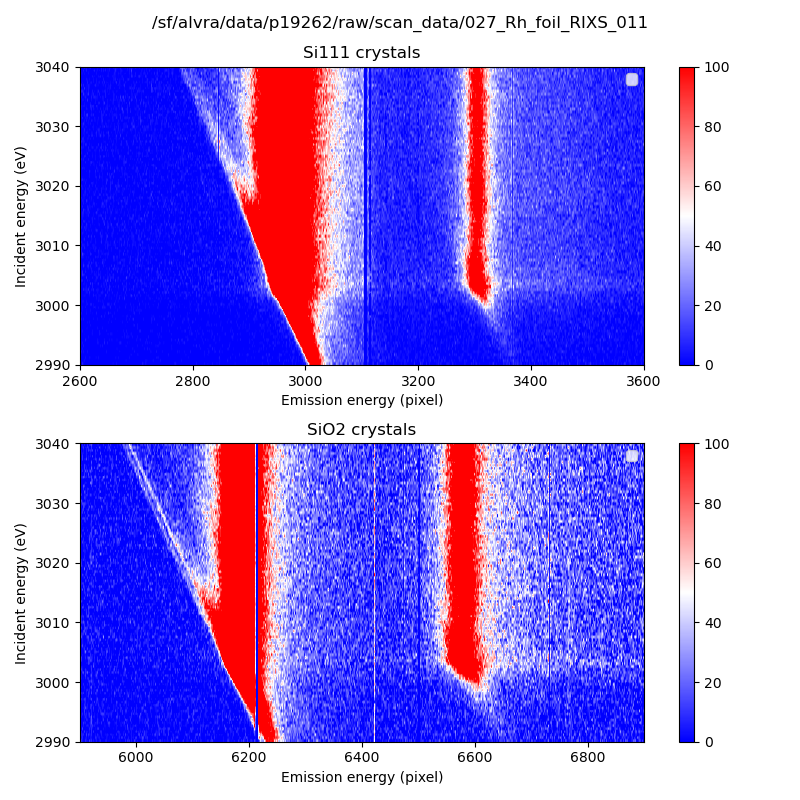

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [183]:
plt.figure(figsize=(8,8))
plt.suptitle(json_file, fontsize=12)

plt.subplot(211)
plt.title('Si111 crystals')
plt.imshow(RIXS_roi1_all_photons, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.title('SiO2 crystals')
plt.imshow(RIXS_roi3_all_photons, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()

plt.tight_layout()
plt.show()


/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


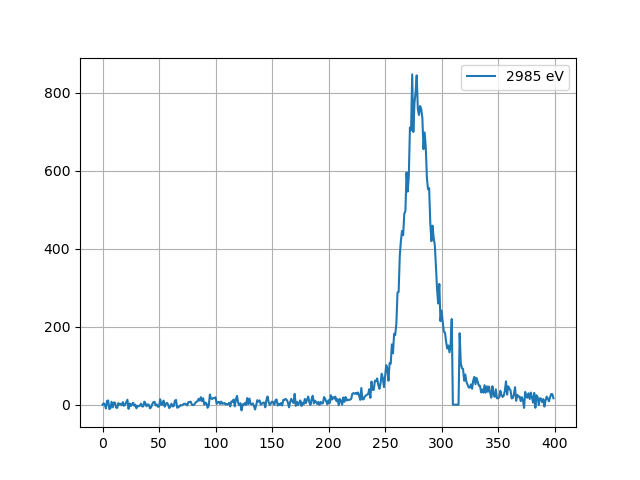

In [83]:
plt.figure()
plt.plot(RIXS_roi3[-5][:400], label ='2985 eV')

#plt.plot(RIXS_roi3[0][:400], label = '3040 eV')
plt.legend(loc='best')
plt.grid()

plt.show()

In [89]:
datalist = []
for file in glob('/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch = datalist[:-1]
patch

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_001',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_002',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_003',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_004',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_005',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_006',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_007',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_008',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_009',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_010',
 '/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil_RIXS_011']

In [94]:
roi1 = (2600, 3600, 200, 260) #signal 1
roi2 = (2600, 3600, 100, 160) #bkg 1

roi3 = (5900, 6900, 200, 260) #signal 2
roi4 = (5900, 6900, 100, 160) #bkg 2

threshold_low = 2.0
threshold_high = 10

channel_list = ['JF02T09V02']

######################################################################################
from sfdata import SFScanInfo

RIXS_roi1_all = []
XAS_roi1_all = []
RIXS_roi3_all = []
XAS_roi3_all = []

for json_file in patch:

    scan = SFScanInfo(fc.selected)
    Energy_eV = scan.readbacks

    XAS_roi1 = []
    XAS_roi3 = []
    calibration = []
    RIXS_roi1 = []
    RIXS_roi3 = []

    for i, step in enumerate(scan.files):

        fn = step[3]
        print (json_file.split('/')[-1])
        print ("File {} out of {}: Processing {}".format(i+1, len(scan.files), fn.split('/')[-1]))

        spectrum_roi1 = 0
        spectrum_roi2 = 0
        spectrum_roi3 = 0
        spectrum_roi4 = 0

        nshots = None

        images_roi1, images_roi2, images_roi3, images_roi4, pids = \
        load_crop_JF_batches(fn, roi1, roi2, roi3, roi4, nshots=nshots)

        images_roi1_thr = images_roi1.copy()
        images_roi1_thr[images_roi1 < threshold_low] = 0
        images_roi1_thr[images_roi1 > threshold_high] = 0

        images_roi2_thr = images_roi2.copy()
        images_roi2_thr[images_roi2 < threshold_low] = 0
        images_roi2_thr[images_roi2 > threshold_high] = 0

        images_roi3_thr = images_roi3.copy()
        images_roi3_thr[images_roi3 < threshold_low] = 0
        images_roi3_thr[images_roi3 > threshold_high] = 0

        images_roi4_thr = images_roi4.copy()
        images_roi4_thr[images_roi4 < threshold_low] = 0
        images_roi4_thr[images_roi4 > threshold_high] = 0


        spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)

        XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
        XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
        #print (np.argmax(spectrum_roi3 - spectrum_roi4))
        calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

        RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
        RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
        clear_output(wait=True)
        print ("It took", clock.tick(), "seconds to process this file")

    RIXS_roi1_all.append(RIXS_roi1)
    XAS_roi1_all.append(XAS_roi1)
    
    RIXS_roi3_all.append(RIXS_roi3)
    XAS_roi3_all.append(XAS_roi3)
    
    print ("\nJob done! It took", clock.tock(), "seconds to process", len(scan.files), "file(s)")

RIXS_roi1_all = np.asarray(RIXS_roi1_all)
XAS_roi1_all = np.asarray(XAS_roi1_all)
RIXS_roi3_all = np.asarray(RIXS_roi3_all)
XAS_roi3_all = np.asarray(XAS_roi3_all)



It took 7.5 seconds to process this file

Job done! It took 21877.1 seconds to process 101 file(s)


In [150]:
xaxis1 = np.linspace(roi3[0]*m+b, roi3[1]*m+b, roi3[1]-roi3[0])

In [171]:
2600 + 357.4

2957.4

<IPython.core.display.Javascript object>


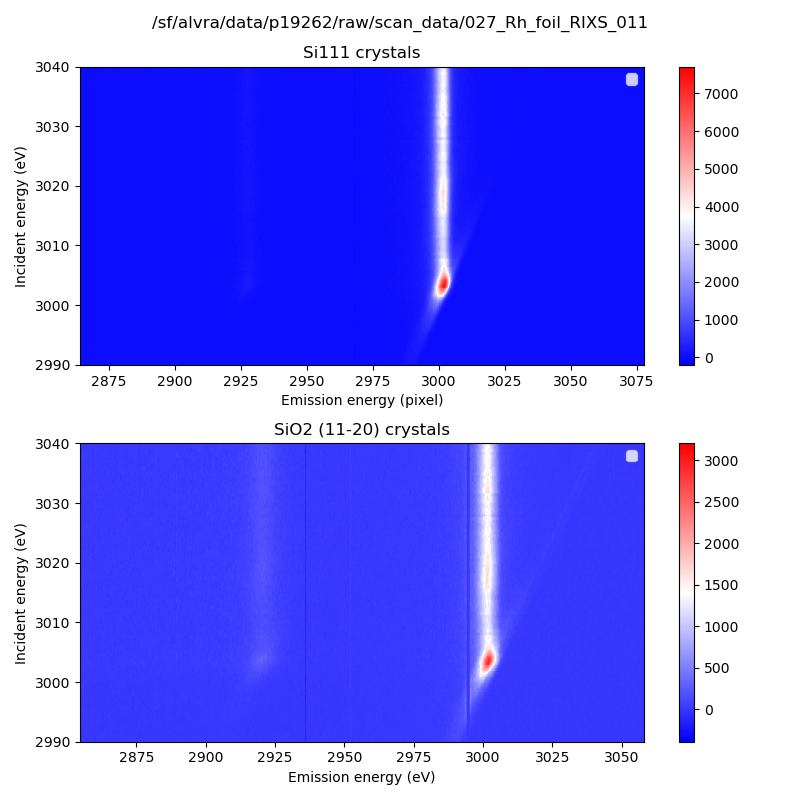

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [185]:
m1 = -0.21348314606741572
b1 = 3001.3 - 2957.4*m1

m3 = -(1/4.913043478260869) 
b3 = 3001.3 - 6179*m3  

#m=1
#b=0
xaxis1 = np.linspace(roi1[0]*m1+b1, roi1[1]*m1+b1, roi1[1]-roi1[0])
xaxis3 = np.linspace(roi3[0]*m3+b3, roi3[1]*m3+b3, roi3[1]-roi3[0])


plt.figure(figsize=(8,8))
plt.suptitle(json_file, fontsize=12)

plt.subplot(211)
plt.title('Si111 crystals')
plt.imshow(RIXS_roi1_all_photons, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[xaxis1[0], xaxis1[-1], Energy_eV[0], Energy_eV[-1]])#, vmin=0, vmax=1000)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.title('SiO2 (11-20) crystals')
plt.imshow(RIXS_roi3_all_photons, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[xaxis3[0], xaxis3[-1], Energy_eV[0],Energy_eV[-1]])#, vmin=0, vmax=1000)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (eV)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()

plt.tight_layout()
plt.show()

In [165]:
1/((2876 - 2787) / 19)

0.21348314606741572

In [194]:
np.shape(RIXS_roi3_all)

(11, 101, 1000)

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


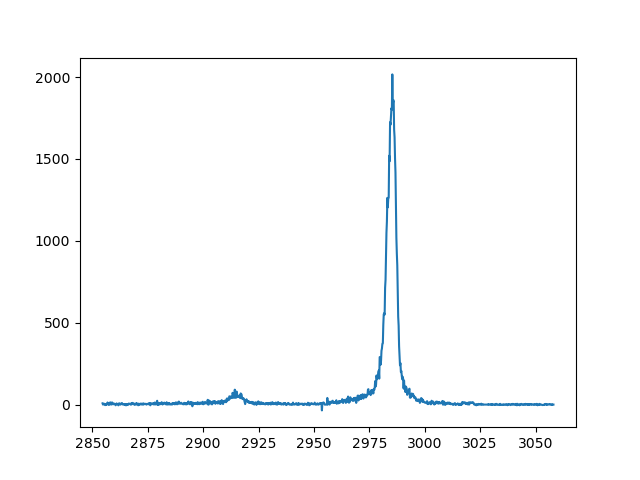

In [197]:

plt.figure()
plt.plot(xaxis3, RIXS_roi1_all[0,-1,:])
plt.show()

In [106]:
np.shape(RIXS_roi3_all)

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(11, 101, 1000)

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


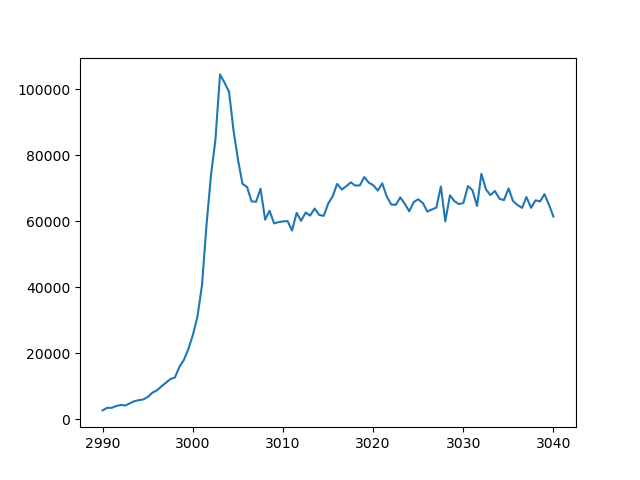

In [108]:
plt.figure()
plt.plot(Energy_eV, np.mean(XAS_roi1_all, axis=0))
plt.show()

## Next cells for an energy, any channel (BSDATA & JF) 

In [12]:
fc = FileChooser('/sf/alvra/data/p18442/res/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18442/res/scan_info', filename='', show_hidden='False')

In [13]:
channel_list = [channel_PIPS_fluo, 'JF02T09V02']

roi1 = (5000, 5150, 220, 290) # Ru La ROIs
roi2 = (5000, 5150, 290, 360) 

roi3 = (2000, 2200, 10, 210)   # Lb _not set correctly!
roi4 = (2000, 2200, 230, 430)   # Kb_background


threshold_low = 2

####################################################################################################3
clock = Clock()
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

XAS_roi1 = []
XAS_roi3 = []
calibration = []
RIXS_roi1 = []
RIXS_roi3 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    spectrum_roi1 = 0
    spectrum_roi2 = 0
    spectrum_roi3 = 0
    spectrum_roi4 = 0
    
    results = load_data_compact(channel_list, step)
    
    Data_fluo = results[channel_PIPS_fluo]
    images = results['JF02T09V02']
    
    images_roi1 = crop_roi(images, roi1)
    images_roi2 = crop_roi(images, roi2)
    images_roi3 = crop_roi(images, roi3)
    images_roi4 = crop_roi(images, roi4)
    
    images_roi1_thr = images_roi1.copy()
    images_roi1_thr[images_roi1 < threshold_low] = 0
    #images_roi1_thr[images_roi1 > threshold_high] = 0
    
    images_roi2_thr = images_roi2.copy()
    images_roi2_thr[images_roi2 < threshold_low] = 0
    #images_roi2_thr[images_roi2 > threshold_high] = 0
    
    images_roi3_thr = images_roi3.copy()
    images_roi3_thr[images_roi3 < threshold_low] = 0
    #images_roi3_thr[images_roi3 > threshold_high] = 0
    
    images_roi4_thr = images_roi4.copy()
    images_roi4_thr[images_roi4 < threshold_low] = 0
    #images_roi4_thr[images_roi4 > threshold_high] = 0
    
    spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
    XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
    #print (np.argmax(spectrum_roi3 - spectrum_roi4))
    calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

    RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
    RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
    
    print ("It took", clock.tick(), "seconds to process this file")
    
XAS_roi1 = np.array(XAS_roi1)
XAS_roi3 = np.array(XAS_roi3)

calibration = np.array(calibration)
RIXS_roi1 = np.array(RIXS_roi1)
RIXS_roi3 = np.array(RIXS_roi3)

print ("\nJob done! It took", clock.tock(), "seconds to process all the files")

Step 41 of 41: Processing run_000952

--------------------------------------------------------------------------------

JF02T09V02               2500 / 4999 -> 50% loss ▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet  4999 / 4999 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET 4999 / 4999 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2500 / 4999 -> 50% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
It took 55.7 seconds to process this file

Job done! It took 2280.56 seconds to process all the files


<IPython.core.display.Javascript object>


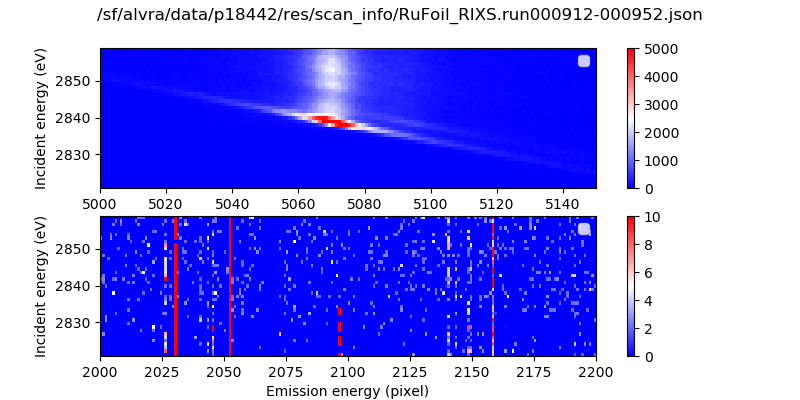

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [14]:
plt.figure(figsize=(8,4))
plt.suptitle(fc.selected, fontsize=12)
plt.subplot(211)
plt.imshow(RIXS_roi1, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=5000)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.imshow(RIXS_roi3, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


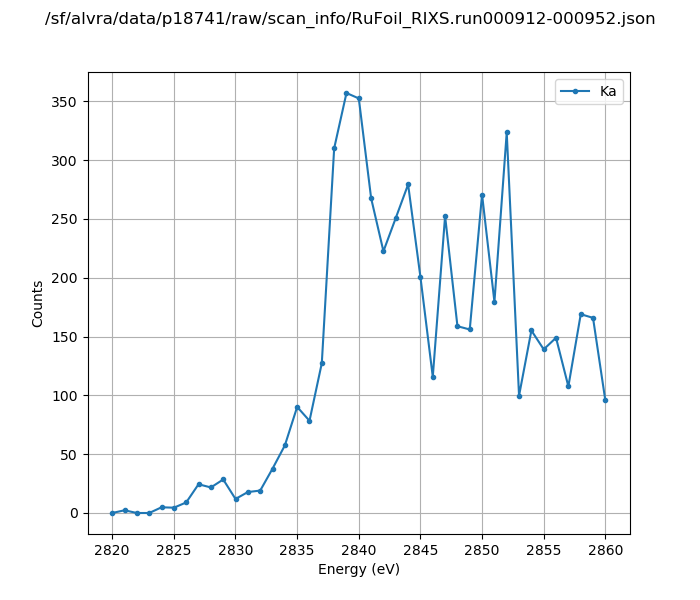

In [29]:
plt.figure(figsize=(7,6))
plt.suptitle(json_file, fontsize=12)

plt.plot(Energy_eV, XAS_roi1,label="Ka", marker='.')
plt.xlabel("Energy (eV)")
plt.ylabel("Counts")
plt.legend(loc="best")
plt.grid()

plt.show()

In [ ]:
def edge_removal(module_edge, roi_removal, array):
    index_edge = module_edge - roi_removal[0]
    array_input = array.copy()
    print (array[index_edge-1:index_edge+3])
    array[index_edge] = array[index_edge-1]/2
    array[index_edge-1] = array[index_edge-1]/2

    array[index_edge+1] = array[index_edge+2]/2
    array[index_edge+2] = array[index_edge+2]/2 
    print (array[index_edge-1:index_edge+3])
    return array, array_input

In [ ]:
spectrum_ON_roi1, spectrum_ON_roi1_orig = edge_removal(6472, roi1, spectrum_ON_roi1) 
spectrum_OFF_roi1, spectrum_OFF_roi1_orig = edge_removal(6472, roi1, spectrum_OFF_roi1) 